# Análise da Bay Area Bike Share

## Introdução

[BABS (Bay Area Bike Share)](http://www.bayareabikeshare.com/) é uma empresa que oferece aluguel de bicicletas on-demand para clientes em San Francisco, Redwood City, Palo Alto, Mountain View e San Jose. Os usuários podem desbloquear bicicletas de uma variedade de estações em cada cidade, e devolvê-las em qualquer estação dentro da mesma cidade. Os usuários pagam o serviço por meio de assinatura anual ou pela compra de passes de 3 dias ou 24 horas. Os usuários podem fazer um número ilimitado de viagens. Viagens com menos de trinta minutos de duração não têm custo adicional; Viagens mais longas incorrem em taxas de horas extras.

# Pergunta 1
Escreva pelo menos duas perguntas que você acha que poderiam ser respondidas usando os dados.

## Resposta

  - Quais estações possuem maior (e menor) número de bicicletas alugadas?
  - Quais horários do dia possuem maior (e menor) número de bicicletas alugadas?

# Pergunta 2
Que visualizações de Tyler você acha que fornecem as idéias mais interessantes?

Selecione duas [visualizações de Tyler](http://thfield.github.io/babs/index.html) que forneçam idéias interessantes e que respondam alguma das perguntas da análise de Tyler.

## Resposta


### Quem são os usuários?
![Quem são os usuarios](who.png)

### Quanto o BABS é utilizado?
![Quanto o BABS é utilizado](usage.png)

# Pergunta 2.1

Quais são as perguntas que foram respondidas com suas visualizações? Porque você as escolheu?

## Resposta
Ambas as perguntas foram respondidas pelas visualizações de Tyler.

Por ser um desenvolvedor _mobile_ (Android) e _full-stack_ (Python e Node.js), as perguntas mais simples que sempre devemos responder sobre os usuários de um aplicativo:

  - Quem são os usuários?
  - Quantos desses usuários geram _revenue_ para a empresa?
  - Qual o _cohort_ dos usuários (i.e. quando e por quanto tempo eles utilizam o aplicativo)?

Tyler mostrou que 80% dos usuários possuem uma assinatura anual, um número eleveado para um serviço não essencial.

Ele também mostrou que, ao contrário do que imaginei, os dias de maiores utilização são _dias úteis_, não finais de semana. Logo existe um algo engajamento no serviço, pois ele é utilizado pelo menos 5 dias por semana.

Ainda que extremamente simples, essas análises podem ser efetuadas sobre o comportamento de qualquer serviço ou produto. Da mesma forma que um desenvolvedor pode criar novos _features_ para aumentar a utilização e lucro de nosso aplicativo.

## Limpeza dos dados

In [1]:
# Importa todas as bibliotecas necessárias
%matplotlib inline
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display

from itertools import cycle, islice

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [2]:
def create_trips_file(file_out, file_in, start_date='10/1/2013'):
    """
    Args:
        file_out   (string): TODO
        file_in    (string): TODO
        start_date (string): TODO
    """
    with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
        in_reader = csv.reader(f_in)
        out_writer = csv.writer(f_out)

        while True:
            datarow = next(in_reader)
            if datarow[2][:9] == start_date:
                break
            out_writer.writerow(datarow)

october_trip_file = 'data/201310_trip_data.csv'
create_trips_file(october_trip_file, 'data/201402_trip_data.csv')

### Condensando os Dados de Viagem

  - Ler arquivo criado anteriormente
  - Imprimir primeiras 7 linhas da tabela


In [3]:
def read_trips(pathname):
    """
    Args:
        pathname (string): File pathname containing trips info

    Returns:
        pd.DataFrame Wrangled information about trips
    """
    df = pd.read_csv(pathname)

    # Clean up all datetime columns
    df['End Date'] = df['End Date'].apply(lambda date: datetime.strptime(date, '%m/%d/%Y %H:%M'))
    df['Start Date'] = df['Start Date'].apply(lambda date: datetime.strptime(date, '%m/%d/%Y %H:%M'))

    return df

def display_table(file_in, n=10):
    sample_data = read_trips(file_in)
    display(sample_data.head(n))

display_table(october_trip_file, 7)

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103
5,4927,103,2013-08-29 18:54:00,Golden Gate at Polk,59,2013-08-29 18:56:00,Golden Gate at Polk,59,527,Subscriber,94109
6,4500,109,2013-08-29 13:25:00,Santa Clara at Almaden,4,2013-08-29 13:27:00,Adobe on Almaden,5,679,Subscriber,95112


### Dados das estações

  - Número de viagens realizadas
  - Momento de início, fim e duração das viagens
  - Origem e destino das viagens.

In [4]:
def read_stations(pathname):
    """
    Args:
        pathname (string): file pathname with stations data in CSV format
    Returns:
        pandas.DataFrame with stations data
    """
    return pd.read_csv(pathname);

def landmarks_by_station(stations):
    """
    Args:
        stations (pandas.DataFrame): Data frame with stations data
    Returns:
        dict with landmark indexed by station ID
    """
    return { row['station_id']: row['landmark'] for i, row in stations.iterrows() }

In [5]:
# Mostra as primeiras linhas do arquivo de dados das estações
station_info = read_stations('data/201402_station_data.csv')
station_info.head()

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


Preencha a função abaixo de forma que a função retorne um mapeamento entre o `id` da estação (`station_id`) e a cidade em que ela se encontra (`landmark`).

In [6]:
def create_station_mapping(pathname):
    """
    Create the mapping between station and city

    Args:
        pathname (string): file pathname with stations data in CSV format
    Returns:
        dict with landmark indexed by station ID
    """
    df = pd.read_csv(pathname)
    return { row['station_id']: row['landmark'] for i, row in df.iterrows() }

Na sequência, você deve criar colunas para o ano, mês, hora e dia da semana. Verifique o tutorial acima ou a [documentação para o objeto de datetime no módulo datetime](https://docs.python.org/2/library/datetime.html#datetime-objects). 

** TODO: Encontre os atributos e métodos necessários para poder completar o código abaixo **

*Dica*: Você pode abrir uma nova caixa para testar um pedaço do código ou verificar uma variável que seja global. Caso ela esteja dentro da função, você também pode usar o comando `print()` para imprimi-la e ajudar no Debug.

In [7]:
def summarise_data(trip_in, station_in, trip_out):
    """
    All your bases are belong to us

    Arguments:
        trip_in  (string): TODO
        stations (dict)  : TODO
        trip_out (string): TODO
    """

    df = read_trips(october_trip_file)
    stations = create_station_mapping(station_in)
    summary = dict()

    # Calculate trip duration in minutes instead of seconds
    summary['duration'] = df['Duration'].apply(lambda duration: float(duration)/60.0)

    # Split trip start datetime into date, year, month, hour, and weekday
    summary['start_date'] = df['Start Date'].apply(lambda isodate: isodate.strftime('%Y-%m-%d'))
    summary['start_year'] = df['Start Date'].apply(lambda iso_date: iso_date.year)
    summary['start_month'] = df['Start Date'].apply(lambda iso_date: iso_date.month)
    summary['start_hour'] = df['Start Date'].apply(lambda iso_date: iso_date.hour)
    summary['weekday'] = df['Start Date'].apply(lambda iso_date: iso_date.weekday())

    # Obtain start/end city from station
    summary['start_city'] = df['Start Terminal'].apply(lambda station_id: stations[station_id])
    summary['end_city'] = df['End Terminal'].apply(lambda station_id: stations[station_id])

    # Subscription type column also named 'subscriber type' in some files
    if 'Subscription Type' in df.columns:
        summary['subscription_type'] = df['Subscription Type']
    else:
        summary['subscription_type'] = df['Subscriber Type']

    trip_out = pd.DataFrame(summary).to_csv()

# Pergunta 3: 
Execute o bloco de código abaixo para chamar a função `summarise_data()` que você terminou na célula acima. Ela usará os dados contidos nos arquivos listados nas variáveis `trip_in` e `station_data` e escreverá um novo arquivo no local especificado na variável `trip_out`. Se você executou a limpeza de dados corretamente, o bloco de código abaixo imprimirá as primeiras linhas do DataFrame e uma mensagem que verificando se as contagens de dados estão corretas.

In [8]:
# processe os dados usando a função criada acima
station_data = 'data/201402_station_data.csv'
trip_in = 'data/201309_trip_data.csv'
trip_out = 'data/201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

In [9]:
# Carregue os dados novamente mostrando os dados
sample_data = pd.read_csv(trip_out)
display(sample_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,3,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,3,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,3,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,3,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,3,San Francisco,San Francisco,Subscriber


In [10]:
# Ensure sample data was wrangled correctly
question_3(sample_data)

Todas as contagens estão como esperadas.


## Análise Exploratória de Dados 

Agora que você tem alguns dados salvos em um arquivo, vejamos algumas tendências iniciais nos dados. Algum código já foi escrito para você no script [babs_visualizations.py](babs_visualizations.py) para ajudar a resumir e visualizar os dados; Isso foi importado como as funções `usage_stats()` e `usage_plot()`. Nesta seção, vamos percorrer algumas das coisas que você pode fazer com as funções, e você usará as funções para você mesmo na última parte do projeto. Primeiro, execute a seguinte célula para carregar os dados. Depois preencha a célula abaixo com os comandos para verificar os dados básicos sobre os dados.

In [11]:
def custom_usage_stats(pathname):
    trip_data = pd.read_csv(pathname)

    print('Existem {:d} pontos no conjunto de dados'.format(len(trip_data)))
    print('A duração média das viagens foi de {:.2f} minutos'.format(trip_data['duration'].mean()))
    print('A mediana das durações das viagens foi de {:.2f} minutos'.format(trip_data['duration'].median()))

    duration_qtiles = trip_data['duration'].quantile([.25, .5, .75]).as_matrix()
    print('25% das viagens foram mais curtas do que {:.2f} minutos'.format(duration_qtiles[0]))
    print('25% das viagens foram mais compridas do que {:.2f} minutos'.format(duration_qtiles[2]))

In [12]:
custom_usage_stats('data/201309_trip_summary.csv')

Existem 27345 pontos no conjunto de dados
A duração média das viagens foi de 27.60 minutos
A mediana das durações das viagens foi de 10.72 minutos
25% das viagens foram mais curtas do que 6.82 minutos
25% das viagens foram mais compridas do que 17.28 minutos


In [13]:
# Ensure custom stats were printed correclty
trip_data = pd.read_csv('data/201309_trip_summary.csv')
usage_stats(trip_data)

Existem 27345 pontos no conjunto de dados
A duração média das viagens foi de 27.60 minutos
A mediana das durações das viagens foi de 10.72 minutos
25% das viagens foram mais curtas do que 6.82 minutos
25% das viagens foram mais compridas do que 17.28 minutos


array([  6.81666667,  10.71666667,  17.28333333])

Você deve ver que há mais de 27.000 viagens no primeiro mês e que a duração média da viagem é maior do que a duração mediana da viagem (o ponto em que 50% das viagens são mais curtas e 50% são mais longas). Na verdade, a média é maior que as durações de 75% das viagens mais curtas. Isso será interessante para ver mais adiante.

In [41]:
def plot_subscription_type(pathname):
    trip_data = pd.read_csv(pathname)
    
    subscription_data = trip_data.groupby('subscription_type')[['duration']].count();

    subscription_data.plot(kind='bar', legend=False, width=0.8, figsize=(8, 6))

    plt.title('Trips by subscription type')
    plt.xlabel('Customer type')
    plt.ylabel('Trips')

def plot_trip(pathname):
    trip_data = pd.read_csv(pathname)
    trip_data['duration'].hist(figsize=(8, 6))

    plt.title('Trips by duration')
    plt.ylabel('Trips')
    plt.xlabel('Duration')
    plt.show()

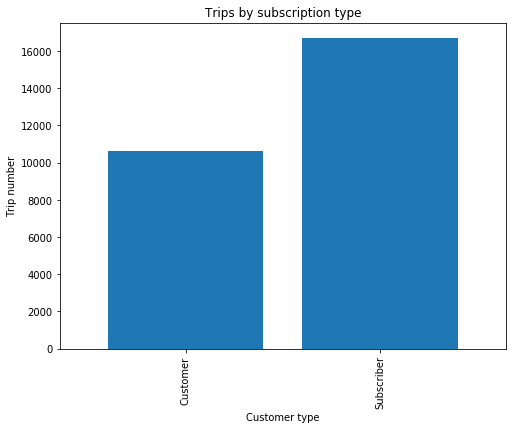

In [15]:
plot_subscription_type('data/201309_trip_summary.csv')

Para que você possa conferir se os seus gráficos estão corretos, usaremos a função `use_plot()`. O segundo argumento da função nos permite contar as viagens em uma variável selecionada, exibindo as informações em um gráfico. A expressão abaixo mostrará como deve ter ficado o seu gráfico acima.

In [ ]:
# como o seu gráfico deve ficar. Descomente a linha abaixo caso queira rodar este comando
usage_plot(trip_data, 'subscription_type')

Parece que existe 50% mais viagens feitas por assinantes (subscribers) no primeiro mês do que outro tipos de consumidores. Vamos tentar uma outra variável. Como é a distribuição da duração das viagens (trip duration)?

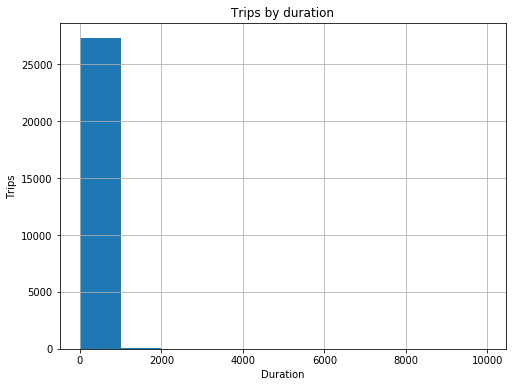

In [42]:
plot_trip('data/201309_trip_summary.csv')

In [31]:
# Ensure sample data was wrangled correctly
# usage_plot(trip_data, 'duration')

,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
duration,,,,,,,,
1.000000,8,8,8,8,8,8,8,8
1.016667,6,6,6,6,6,6,6,6
1.033333,2,2,2,2,2,2,2,2
1.050000,5,5,5,5,5,5,5,5
1.066667,2,2,2,2,2,2,2,2


Parece muito estranho, não é? Dê uma olhada nos valores de duração no eixo x. A maioria dos passeios deve ser de 30 minutos ou menos, uma vez que há taxas de excesso de tempo extra em uma única viagem. A primeira barra abrange durações de até 1000 minutos, ou mais de 16 horas. Com base nas estatísticas que obtivemos do `use_stats()`, deveríamos ter esperado algumas viagens com durações muito longas que levem a média a ser muito superior à mediana: o gráfico mostra isso de forma dramática, mas inútil.

Ao explorar os dados, muitas vezes você precisará trabalhar com os parâmetros da função de visualização para facilitar a compreensão dos dados. É aqui que os filtros vão ajudar você. Comecemos por limitar as  viagens de menos de 60 minutos.

In [ ]:
# TODO: faça um gráfico de barras para os dados com duração inferior a 60 minutos.

In [ ]:
# descomente a linha abaixo para verificar o gráfico esperado.
# usage_plot(trip_data, 'duration', ['duration < 60'])

Isso está bem melhor! Você pode ver que a maioria das viagens têm menos de 30 minutos de duração, mas que você pode fazer mais para melhorar a apresentação. Uma vez que a duração mínima não é 0, a barra da esquerda está ligeiramente acima de 0. Nós queremos saber onde existe um limite perto dos 30 minutos, então ficará mais agradável se tivermos tamanhos de intervalos (bin sizes) e limites dos intervalos que correspondam a alguns minutos. 

Felizmente, o Pandas e o Matplotlib te dão a opção de resolver ester problemas. Uma das maneiras de fazê-lo é definindo qual o intervalo no eixo x (parâmetro range) e quantos intervalos desejamos (bins).

No campo abaixo, faça o ajuste do gráfico para que os limites das barras se encontrem nas extremidades e que as barras tenham tamanho 5 (0, 5, 10, 15, etc). Se precisar, use a [documentação](http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.hist.html#matplotlib.axes.Axes.hist).

In [ ]:
# faça o gráfico ajustado que começará no 0 e terá o bin size de 5

In [ ]:
# rode esta linha para verificar como deve ficar o seu gráfico
#usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

Pequenos ajustes como este podem ser pequenos mas fazem toda a diferença na entrega de um trabalho de qualidade e com atenção aos detalhes.


# Pergunta 3

Analise o histograma do exercicio anterior e responda:

Qual o intervalo de duração com maior quantidade de viagens?


**Reposta**: Substitua este texto pela sua resposta!

# Pergunta 4.1

Com base na sua resposta da pergunta anterior, conte quantas viagens existem para cada origem e destino desse intervalo de tempo. Monte uma tabela que demonstre isso. 

Qual origem e destino tem a maior quantidade de viagens?  Aproximadamente quantas viagens foram feitas nesta faixa de tempo?


 **Reposta**: Substitua este texto pela sua resposta!

## Fazendo suas Próprias Análises

Agora que você fez alguma exploração em uma pequena amostra do conjunto de dados, é hora de avançar e reunir todos os dados em um único arquivo e ver quais tendências você pode encontrar. O código abaixo usará a mesma função `summarise_data()` para processar dados. Depois de executar a célula abaixo, você terá processado todos os dados em um único arquivo de dados. Observe que a função não exibirá qualquer saída enquanto ele é executado, e isso pode demorar um pouco para ser concluído, pois você tem muito mais dados do que a amostra com a qual você trabalhou.

In [ ]:
station_data = [
    '201402_station_data.csv',
    '201408_station_data.csv',
    '201508_station_data.csv'
]

trip_in = [
    '201402_trip_data.csv',
    '201408_trip_data.csv',
    '201508_trip_data.csv'
]

trip_out = 'babs_y1_y2_summary.csv'

# Esta função irá ler as informações das estações e das viagens
# e escreverá um arquivo processado com o nome trip_out
summarise_data(trip_in, station_data, trip_out)

Já que a função `summarise_data()` escreveu um arquivo de saída, a célula acima não precisa ser rodada novamente mesmo que este notebook seja fechado e uma nova sessão seja criada. Você pode simplesmente ler os dados novamente e fazer a exploração deste ponto (não esqueça de executar a parte das funções no começo do notebook caso esteja em uma nova sessão)

In [ ]:
trip_data = pd.read_csv('babs_y1_y2_summary.csv')
display(trip_data.head())

#### Agora é a SUA vez de fazer a exploração do dataset (do conjunto de dados) completo.

Aproveite para fazer filtros nos dados e tentar encontrar padrões nos dados.

Explore algumas variáveis diferentes usando o mesmo racional acima e tome nota de algumas tendências que você encontra. Sinta-se livre para criar células adicionais se quiser explorar o conjunto de dados de outras maneiras ou de várias maneiras.

> **Dica**: para adicionar células adicionais a um notebook, você pode usar as opções "Inserir célula acima" (Insert Cell Above) e "Insert Cell Below" na barra de menu acima. Há também um ícone na barra de ferramentas para adicionar novas células, com ícones adicionais para mover as células para cima e para baixo do documento. Por padrão, as novas células são do tipo de código; Você também pode especificar o tipo de célula (por exemplo, Código ou Markdown) das células selecionadas no menu Cell ou no menu dropdown na barra de ferramentas.

Um feito com suas explorações, copie as duas visualizações que você achou mais interessantes nas células abaixo e responda as seguintes perguntas com algumas frases descrevendo o que você encontrou e por que você selecionou os números. Certifique-se de que você ajusta o número de caixas ou os limites da bandeja para que efetivamente transmitam os resultados dos dados. Sinta-se livre para complementar isso com quaisquer números adicionais gerados a partir de `use_stats()` ou coloque visualizações múltiplas para suportar suas observações.

Para ver alguns outros tipos de gráficos que o matplotlib (padrão do Pandas) possui, leia [este artigo](https://www.labri.fr/perso/nrougier/teaching/matplotlib/#other-types-of-plots). 

Para entender um pouco mais como e quais gráficos podem ser úteis, leia [este documento](https://www.tableau.com/sites/default/files/media/Whitepapers/which_chart_v6_ptb.pdf). Ele lhe dará um pouco de idéia de como mostrar os dados de forma mais acertada

# Pergunta 5a
Explore os dados e faça um gráfico que demonstre alguma particularidade dos dados:

In [ ]:
# Gráfico final 1


O que é interessante na visualização acima? Por que você a selecionou?

**Answer**: Escreva a sua resposta aqui

# Pergunta 5b
Faça um gráfico que demonstre alguma particularidade dos dados:

In [ ]:
# Gráfico Final 2

O que é interessante na visualização acima? Por que você a selecionou?

**Answer**: Escreva a sua resposta aqui

## Conclusões

Parabéns pela conclusão do projeto! Esta é apenas uma amostragem do processo de análise de dados: gerando perguntas, limpando e explorando os dados. Normalmente, neste momento no processo de análise de dados, você pode querer tirar conclusões realizando um teste estatístico ou ajustando os dados a um modelo para fazer previsões. Há também muitas análises potenciais que podem ser realizadas se evoluirmos o código fornecido. Em vez de apenas olhar para o número de viagens no eixo de resultados, você pode ver quais recursos afetam coisas como a duração da viagem. Nós também não analisamos como os dados meteorológicos se encaixam no uso de bicicletas.

# Pergunta 6
Pense em um tópico ou campo de interesse onde você gostaria de poder aplicar as técnicas da ciência dos dados. O que você gostaria de aprender com o assunto escolhido?

**Responda**: Substitua este texto pela sua resposta!

> **Dica**: se quisermos compartilhar os resultados de nossa análise com os outros, existe uma outra opção que não é enviar o arquivo jupyter Notebook (.ipynb). Também podemos exportar a saída do Notebook de uma forma que pode ser aberto mesmo para aqueles sem o Python instalado. No menu **File** na parte superior esquerda, vá para o submenu **Download as**. Você pode então escolher um formato diferente que pode ser visto de forma mais geral, como HTML (.html) ou PDF (.pdf). Você pode precisar de pacotes adicionais ou software para executar essas exportações.

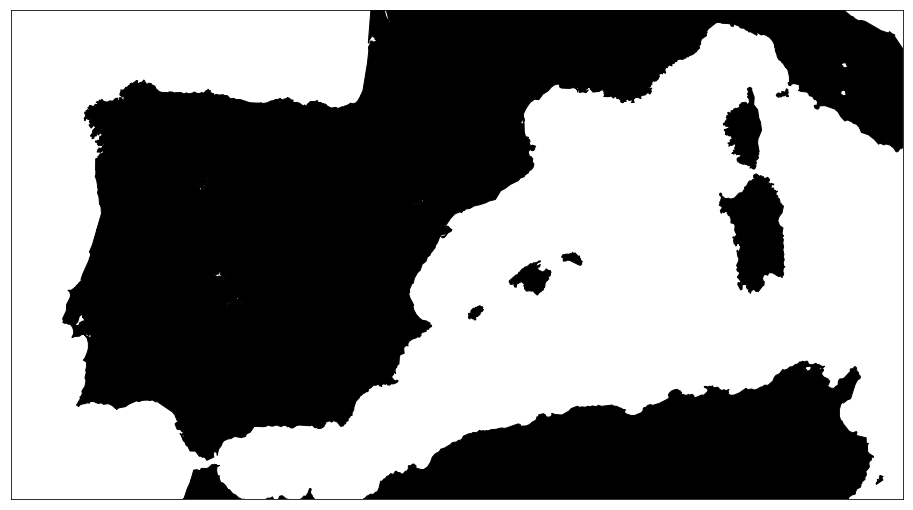

In [12]:
plt.figure(figsize=(16, 9))

atlas = Basemap(
    llcrnrlon=-10.5,
    llcrnrlat=35,
    urcrnrlon=14.,
    urcrnrlat=44.,
    resolution='i',
    projection='tmerc',
    lat_0 = 39.5,
    lon_0 = -3.25
)

# atlas.drawmapboundary(fill_color='#ffffff')
atlas.fillcontinents(color='#000000',lake_color='#ffffff')
atlas.drawcoastlines()

plt.show()

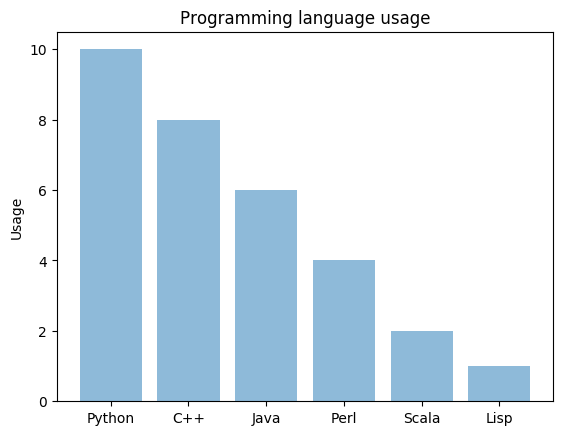

In [140]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()